In [1]:
import re

### Feed Forward Neural Network Parameters

In [2]:
SEED = 673
# 1st Layer
LAYER1_SIZE = 16
LAYER1_ACTIVATION = 'relu'
LAYER1_INPUT_DIMENSION = 10000

LAYER1_PARAMS = [str(LAYER1_SIZE), LAYER1_ACTIVATION, LAYER1_INPUT_DIMENSION]

# 2nd LAYER
LAYER2_SIZE = 16
LAYER2_ACTIVATION = 'relu'

LAYER2_PARAMS = [str(LAYER2_SIZE), LAYER2_ACTIVATION]

# 3rd LAYER
LAYER3_SIZE = 4
LAYER3_ACTIVATION = 'sigmoid'

LAYER3_PARAMS = [str(LAYER3_SIZE), LAYER3_ACTIVATION]

# Geralizers
DROPOUT_RATE = 0.5
L1 = 0.001
L2 = 0.001

# TRAINING
EPOCHS = 3
BATCH_SIZE = 128

TRAIN_PARAMS = [EPOCHS, BATCH_SIZE]

# COMPILATION
OPTIMIZER = 'rmsprop'
LOSS = 'binary_crossentropy'
METRICS = 'accuracy'

COMPILATION_PARAMS = [OPTIMIZER, LOSS, METRICS]

### Over Sampling with SMOTE

In [45]:
# This file contains 8600ish users Data
# In the form: {'MBTI Type', 'Social Media Posts'}
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

data = pd.read_csv('mbti_1.csv')

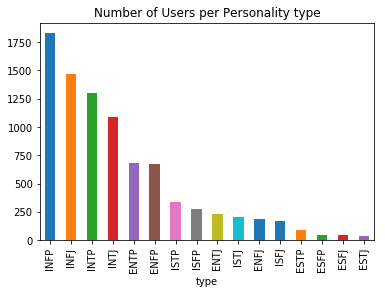

In [56]:
type_distribution = data.groupby("type").count().sort_values("posts", ascending=False)
type_distribution["posts"].plot(kind="bar", title="Number of Users per Personality type")

Obviously, The data is very much inbalanced. By my calculations about 76% Introver to Extrovert. Our original models were statistically invalid, as overfitting happen basically instantaneously.

In [67]:
import pickle

tokenized_posts = []
with open ('tokenized_formatted_data.txt', 'rb') as fp:
    tokenized_posts = pickle.load(fp)
    
types = data.type
posts = data.posts
l

8675

In [8]:
import pickle

tokenized_posts = []
with open ('tokenized_formatted_data.txt', 'rb') as fp:
    tokenized_posts = pickle.load(fp)

In [9]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [10]:
from collections import Counter

In [11]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [12]:
dictionary = list(zip(*dictionary))[0]

In [13]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [14]:
x_vals = []

for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [15]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

one_hot_types = []
for type in types:
    bin_type = []
    if (type[0] == 'I'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (type[1] == 'N'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (type[2] == 'T'):
        bin_type.append(0)
    else:
        bin_type.append(1)
    
    if (type[3] == 'J'):
        bin_type.append(0)
    else:
        bin_type.append(1)
    one_hot_types.append(bin_type)
    

In [16]:
import numpy as np
import random

x = np.array(x_vals)
random.seed(SEED)
random.shuffle(x)
test_data = x[:1500]
train_data = x[1500:]

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [17]:
from keras.utils.np_utils import to_categorical

y = np.asarray(one_hot_types).astype('float32')
random.seed(SEED)
random.shuffle(y)
y_test = y[:1500]
y_train = y[1500:]

Using TensorFlow backend.


In [18]:
x_val = x_train[:1500]
x_partial_train = x_train[1500:]

y_val = y_train[:1500]
y_partial_train = y_train[1500:]

In [27]:
# FEED FORWARD MODEL

from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
#kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(LAYER1_SIZE, activation=LAYER1_ACTIVATION, input_shape = (LAYER1_INPUT_DIMENSION,)))
    model.add(layers.Dense(LAYER2_SIZE, activation=LAYER2_ACTIVATION))
    model.add(layers.Dense(LAYER3_SIZE, activation=LAYER3_ACTIVATION))
    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = ['accuracy'])
    return model

In [28]:
model = build_model()
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/3
7175/7175 [==============================] - 3s 384us/step - loss: 0.5835 - acc: 0.6876
Epoch 2/3
7175/7175 [==============================] - 1s 128us/step - loss: 0.5316 - acc: 0.7433
Epoch 3/3
1500/1500 [==============================] - 0s 170us/step


[0.6218339424133301, 0.6828333330154419]